In [1]:
#LETS LOAD IN THE LIBRARIES

library(tm)
library(ggplot2)
library(wordcloud)
library(tidytext)
library(syuzhet)
library(dplyr)
library(stringr)
library(pryr)
library(tidyr)
library(reshape)
library(lubridate)
library(rtweet)
library(maps)
library(ggmap)
library(gganimate)
library(SnowballC)


Loading required package: NLP

Attaching package: ‘ggplot2’

The following object is masked from ‘package:NLP’:

    annotate

Loading required package: RColorBrewer

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘pryr’

The following object is masked from ‘package:tm’:

    inspect


Attaching package: ‘reshape’

The following objects are masked from ‘package:tidyr’:

    expand, smiths

The following object is masked from ‘package:dplyr’:

    rename


Attaching package: ‘lubridate’

The following object is masked from ‘package:reshape’:

    stamp

The following object is masked from ‘package:base’:

    date


Attaching package: ‘rtweet’

The following object is masked from ‘package:syuzhet’:

    get_tokens

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it!

In [2]:
.libPaths("r-libs")

In [3]:
library(textfeatures)


In [4]:
#READ IN THE TWEET CSV AND THE RATE OF VACCINATION CSV
tweetwithoutbot = read.csv("../Resources/pytweetwithoutbot.csv")
rate = read.csv("../01 Data Carpentry/resources/state_rate.csv")
#LETS SEE WHAT COLUMNS ARE IN THE RATE CSV
colnames(rate)

[1] "State"       "Year"        "Rate"        "Sample.Size"

In [5]:
#CONVERT STATE TO LOWERCASE
rate$State<-tolower(rate$State)

#RENAME THE COLUMNS SO THE COLUMN NAMES ARE LOWERCASE FOR WHEN STATE_MAPS IS JOINED LATER
colnames(rate)[colnames(rate)=="State"] <- "state"
colnames(rate)[colnames(rate)=="Year"] <- "year"

In [6]:
#LETS ALSO READ IN THE PREDICTIONS OUTPUT
preds = read.csv("../Resources/predictions.csv")

In [7]:
#NEED THE CUMULATIVE SENT. SCORE
tweetwithoutbot<-tweetwithoutbot %>%
mutate(cum_score = positive-negative)

In [8]:
#LETS CONFIRM IT SHOWS
head(tweetwithoutbot)
colnames(tweetwithoutbot)

X year state      display_text_width is_quote favorite_count retweet_count
1 0 2006 california  104               0        0              0            
2 1 2007 alabama      84               0        0              0            
3 2 2007 arizona    1744               0        0              0            
4 3 2007 arkansas    101               0        0              0            
5 4 2007 california 6234               0        0              0            
6 5 2007 colorado    981               0        0              0            
  quoted_favorite_count quoted_retweet_count quoted_followers_count ⋯
1 0                     0                    0                      ⋯
2 0                     0                    0                      ⋯
3 0                     0                    0                      ⋯
4 0                     0                    0                      ⋯
5 0                     0                    0                      ⋯
6 0                     0                    0                      ⋯
  sent_vader n_polite  n_first_person n_first_personp n_second_person
1  1.9        0.000000  0             0               0              
2  2.0        0.200000  0             0               0              
3 24.3       -1.150000  4             5               0              
4 -3.2        0.000000  0             0               0              
5 50.6       -2.936111 32             3               5              
6  5.2        0.200000  7             0               0              
  n_second_personp cnt n_tobe text cum_score
1 0                0    0      1    1       
2 0                0    0      1    0       
3 1                0    7     19    2       
4 0                0    0      1    0       
5 3                5   21     67   -5       
6 1                1    6     10   -7

[1] "X"                      "year"                   "state"                 
 [4] "display_text_width"     "is_quote"               "favorite_count"        
 [7] "retweet_count"          "quoted_favorite_count"  "quoted_retweet_count"  
[10] "quoted_followers_count" "quoted_friends_count"   "quoted_statuses_count" 
[13] "followers_count"        "friends_count"          "listed_count"          
[16] "statuses_count"         "favourites_count"       "verified"              
[19] "lat"                    "lng"                    "anger"                 
[22] "anticipation"           "disgust"                "fear"                  
[25] "joy"                    "sadness"                "surprise"              
[28] "trust"                  "negative"               "positive"              
[31] "score"                  "n_urls"                 "n_uq_urls"             
[34] "n_hashtags"             "n_uq_hashtags"          "n_mentions"            
[37] "n_uq_mentions"          "n_chars"                "n_uq_chars"            
[40] "n_commas"               "n_digits"               "n_exclaims"            
[43] "n_extraspaces"          "n_lowers"               "n_lowersp"             
[46] "n_periods"              "n_words"                "n_uq_words"            
[49] "n_caps"                 "n_nonasciis"            "n_puncts"              
[52] "n_capsp"                "n_charsperword"         "sent_afinn"            
[55] "sent_bing"              "sent_syuzhet"           "sent_vader"            
[58] "n_polite"               "n_first_person"         "n_first_personp"       
[61] "n_second_person"        "n_second_personp"       "cnt"                   
[64] "n_tobe"                 "text"                   "cum_score"

In [9]:
#EXAMINE THE STRUCTURE
str(tweetwithoutbot)

'data.frame':	546 obs. of  66 variables:
 $ X                     : int  0 1 2 3 4 5 6 7 8 9 ...
 $ year                  : int  2006 2007 2007 2007 2007 2007 2007 2007 2007 2007 ...
 $ state                 : Factor w/ 51 levels "alabama","alaska",..: 5 1 3 4 5 6 7 9 10 11 ...
 $ display_text_width    : int  104 84 1744 101 6234 981 733 458 431 193 ...
 $ is_quote              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ favorite_count        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ retweet_count         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ quoted_favorite_count : num  0 0 0 0 0 0 0 0 0 0 ...
 $ quoted_retweet_count  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ quoted_followers_count: num  0 0 0 0 0 0 0 0 0 0 ...
 $ quoted_friends_count  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ quoted_statuses_count : num  0 0 0 0 0 0 0 0 0 0 ...
 $ followers_count       : num  16459 358 290048 641 3181356 ...
 $ friends_count         : int  637 47 20963 760 51617 30723 4643 3942 2276 1195 ...
 $ listed_count          : int  1242 31 4548 7

In [10]:
#LETS LOOK AT STATES INFORMATION AN EXCLUDE DC FROM THIS. WE WANT TO BE ABLE JOIN OUR DATA WITH A US MAP
states_map <- map_data("state")
states_map <- states_map[states_map$region!="district of columbia",]
#CONFIRM EVERYTHING IS LOWER CASE
tweetwithoutbot$state<-tolower(tweetwithoutbot$state)
#LOOK AT UNIQUE STATES SO I CAN CONFIRM DC WAS REMOVED
unique(states_map$region)

[1] "alabama"        "arizona"        "arkansas"       "california"    
 [5] "colorado"       "connecticut"    "delaware"       "florida"       
 [9] "georgia"        "idaho"          "illinois"       "indiana"       
[13] "iowa"           "kansas"         "kentucky"       "louisiana"     
[17] "maine"          "maryland"       "massachusetts"  "michigan"      
[21] "minnesota"      "mississippi"    "missouri"       "montana"       
[25] "nebraska"       "nevada"         "new hampshire"  "new jersey"    
[29] "new mexico"     "new york"       "north carolina" "north dakota"  
[33] "ohio"           "oklahoma"       "oregon"         "pennsylvania"  
[37] "rhode island"   "south carolina" "south dakota"   "tennessee"     
[41] "texas"          "utah"           "vermont"        "virginia"      
[45] "washington"     "west virginia"  "wisconsin"      "wyoming"

In [11]:
#LETS CHECK OUR OUTPUT ON STATE DATA
tweetwithoutbot$state

[1] "california"     "alabama"        "arizona"        "arkansas"      
  [5] "california"     "colorado"       "connecticut"    "florida"       
  [9] "georgia"        "hawaii"         "idaho"          "illinois"      
 [13] "indiana"        "kansas"         "kentucky"       "louisiana"     
 [17] "maryland"       "massachusetts"  "michigan"       "minnesota"     
 [21] "missouri"       "nebraska"       "nevada"         "new hampshire" 
 [25] "new jersey"     "new mexico"     "new york"       "north carolina"
 [29] "ohio"           "oregon"         "pennsylvania"   "rhode island"  
 [33] "south carolina" "tennessee"      "texas"          "united states" 
 [37] "vermont"        "virginia"       "washington"     "wisconsin"     
 [41] "alabama"        "alaska"         "arizona"        "arkansas"      
 [45] "california"     "colorado"       "connecticut"    "delaware"      
 [49] "florida"        "georgia"        "hawaii"         "idaho"         
 [53] "illinois"       "indiana"        "iowa"           "kansas"        
 [57] "kentucky"       "louisiana"      "maine"          "maryland"      
 [61] "massachusetts"  "michigan"       "minnesota"      "mississippi"   
 [65] "missouri"       "montana"        "nebraska"       "nevada"        
 [69] "new hampshire"  "new jersey"     "new mexico"     "new york"      
 [73] "north carolina" "north dakota"   "ohio"           "oklahoma"      
 [77] "oregon"         "pennsylvania"   "rhode island"   "south carolina"
 [81] "south dakota"   "tennessee"      "texas"          "united states" 
 [85] "utah"           "vermont"        "virginia"       "washington"    
 [89] "west virginia"  "wisconsin"      "wyoming"        "alabama"       
 [93] "alaska"         "arizona"        "arkansas"       "california"    
 [97] "colorado"       "connecticut"    "delaware"       "florida"       
[101] "georgia"        "hawaii"         "idaho"          "illinois"      
[105] "indiana"        "iowa"           "kansas"         "kentucky"      
[109] "louisiana"      "maine"          "maryland"       "massachusetts" 
[113] "michigan"       "minnesota"      "mississippi"    "missouri"      
[117] "montana"        "nebraska"       "nevada"         "new hampshire" 
[121] "new jersey"     "new mexico"     "new york"       "north carolina"
[125] "north dakota"   "ohio"           "oklahoma"       "oregon"        
[129] "pennsylvania"   "rhode island"   "south carolina" "south dakota"  
[133] "tennessee"      "texas"          "united states"  "utah"          
[137] "vermont"        "virginia"       "washington"     "west virginia" 
[141] "wisconsin"      "wyoming"        "alabama"        "alaska"        
[145] "arizona"        "arkansas"       "california"     "colorado"      
[149] "connecticut"    "delaware"       "florida"        "georgia"       
[153] "hawaii"         "idaho"          "illinois"       "indiana"       
[157] "iowa"           "kansas"         "kentucky"       "louisiana"     
[161] "maine"          "maryland"       "massachusetts"  "michigan"      
[165] "minnesota"      "mississippi"    "missouri"       "montana"       
[169] "nebraska"       "nevada"         "new hampshire"  "new jersey"    
[173] "new mexico"     "new york"       "north carolina" "north dakota"  
[177] "ohio"           "oklahoma"       "oregon"         "pennsylvania"  
[181] "rhode island"   "south carolina" "south dakota"   "tennessee"     
[185] "texas"          "united states"  "utah"           "vermont"       
[189] "virginia"       "washington"     "west virginia"  "wisconsin"     
[193] "wyoming"        "alabama"        "alaska"         "arizona"       
[197] "arkansas"       "california"     "colorado"       "connecticut"   
[201] "delaware"       "florida"        "georgia"        "hawaii"        
[205] "idaho"          "illinois"       "indiana"        "iowa"          
[209] "kansas"         "kentucky"       "louisiana"      "maine"         
[213] "maryland"       "massachusetts"  "michigan"       "minnesota"     
[217] 

In [12]:
#I DONT WANT TO SEE SCIENTIFIC NOTATION
options(scipen=999)

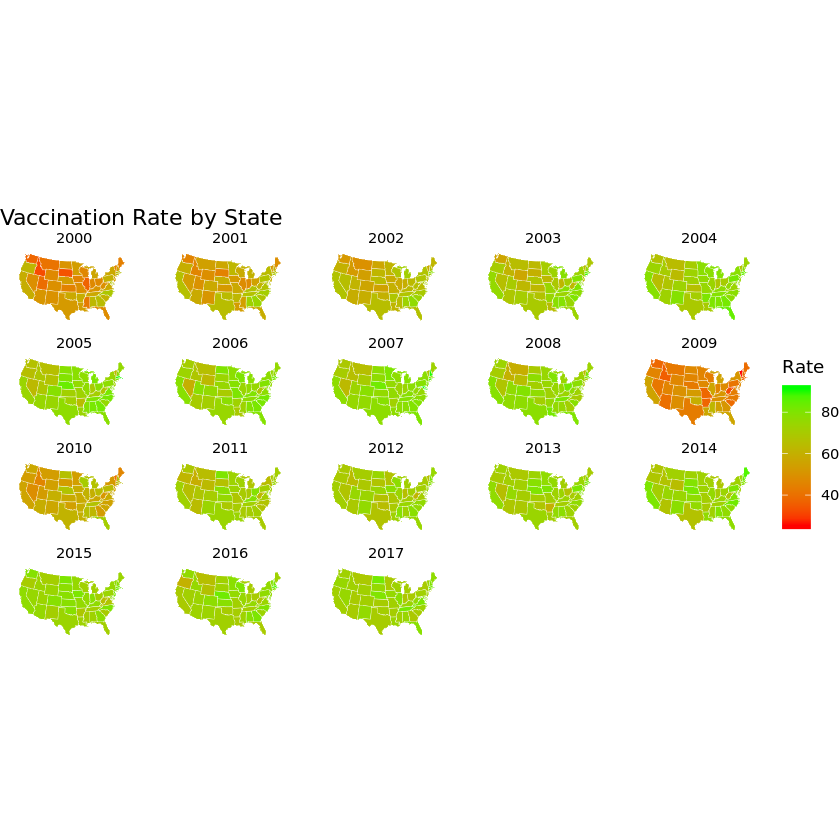

In [13]:
##RATE## LETS PLOT THE RATE AND VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=rate, aes(fill=Rate)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "red", high = "green", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Rate" ,title = "Vaccination Rate by State", x="", y="")+
theme_void() + facet_wrap(~year)


#FACET WRAP SPLITS OUT EACH MAP BY YEAR


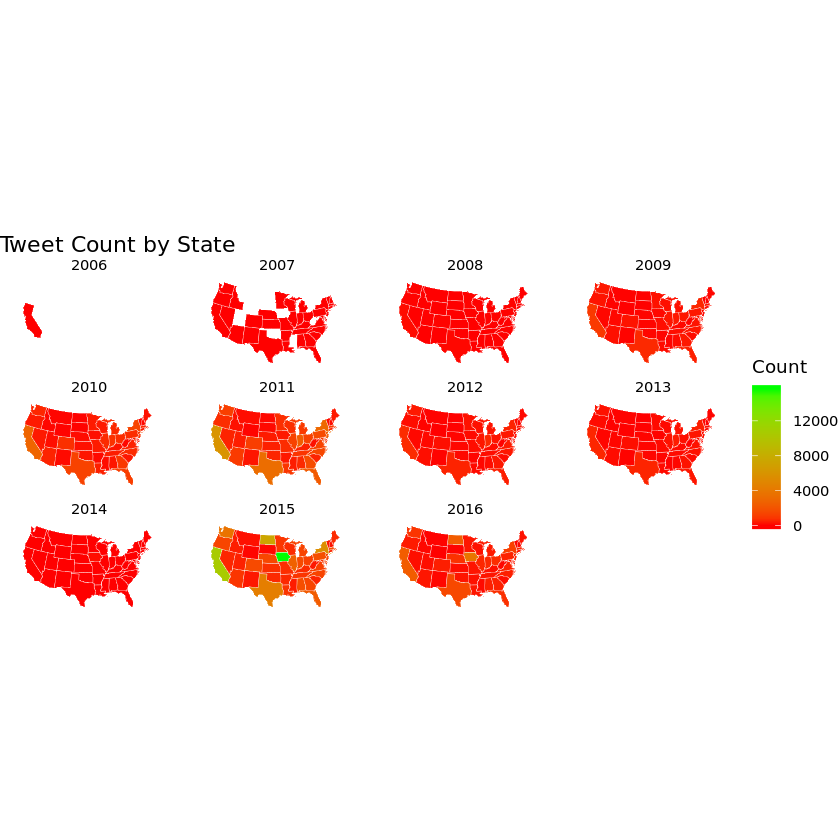

In [14]:
##COUNT## LETS PLOT THE COUNT AND VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "red", high = "green", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Count" ,title = "Tweet Count by State", x="", y="")+
theme_void() + facet_wrap(~year)






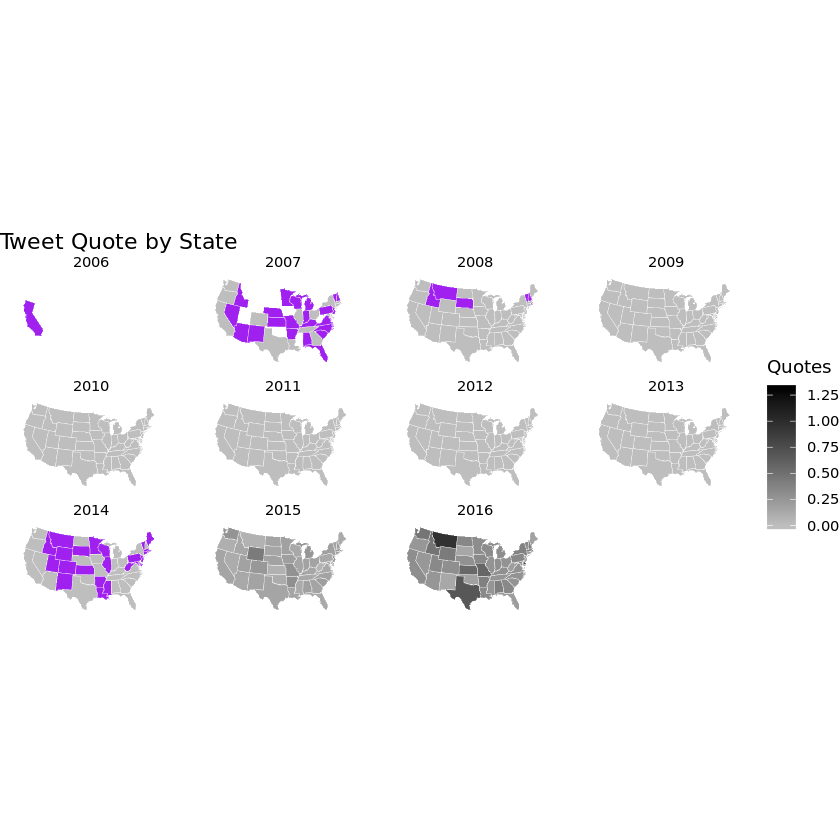

In [15]:
##QUOTE## LETS PLOT THE QUOTES AND VIEW QUANTITATIVE DATA ON GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=is_quote/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "gray", high = "black", guide="colorbar",na.value="purple") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Quotes" 
                            ,title = "Tweet Quote by State", x="", y="")+
theme_void() + facet_wrap(~year)

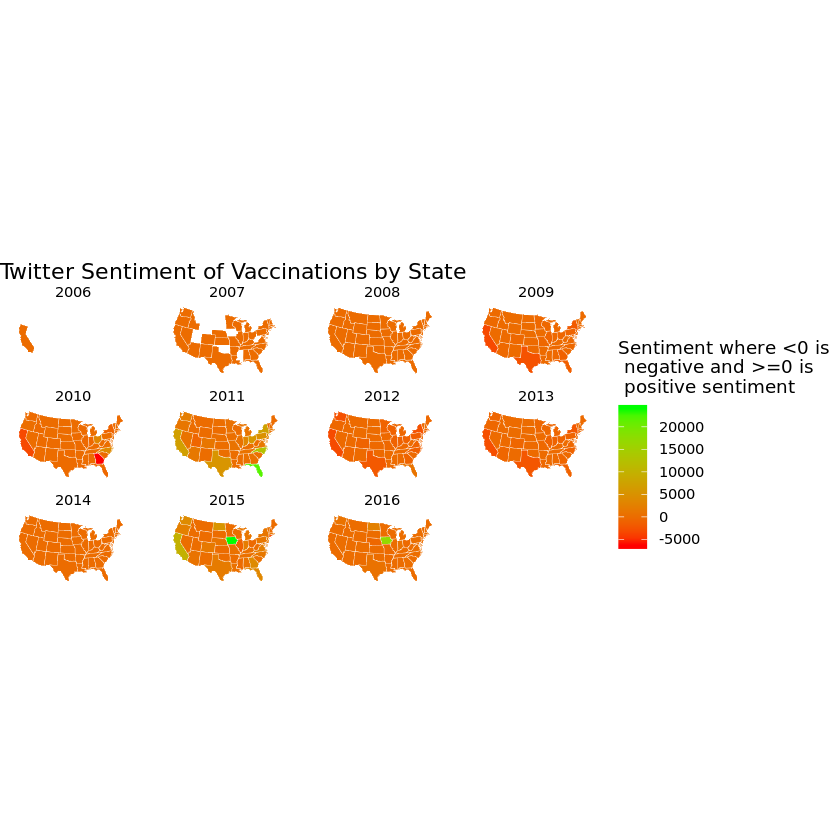

In [16]:
##SENTIMENT SCORE## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=cum_score)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "red", high = "green", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Sentiment where <0 is \n negative and >=0 is \n positive sentiment " 
                            ,title = "Twitter Sentiment of Vaccinations by State", x="", y="")+
theme_void() + facet_wrap(~year)

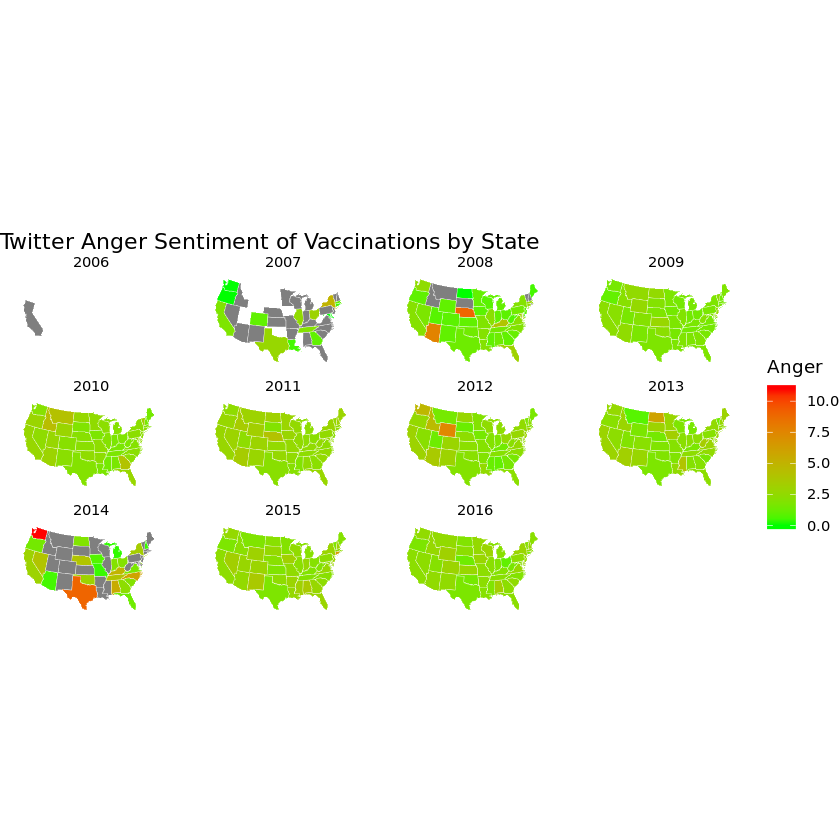

In [17]:
##ANGER## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=anger/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "green", high = "red", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Anger " 
                            ,title = "Twitter Anger Sentiment of Vaccinations by State", x="", y="")+
theme_void() + facet_wrap(~year)

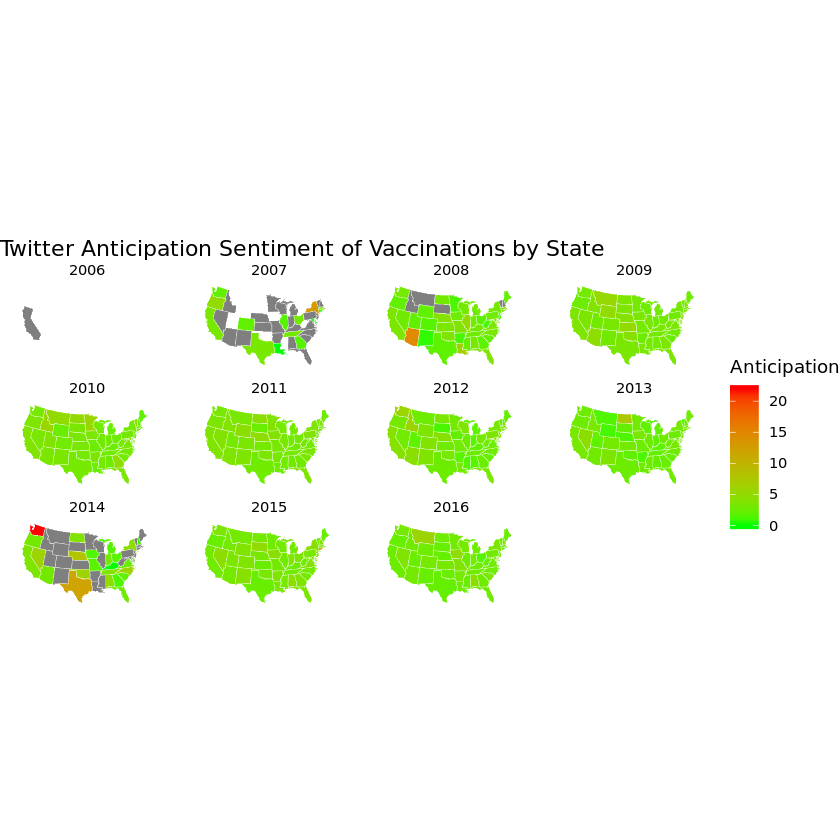

In [18]:
 ##ANTICIPATION## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=anticipation/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "green", high = "red", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Anticipation" 
                            ,title = "Twitter Anticipation Sentiment of Vaccinations by State", x="", y="")+
theme_void() + facet_wrap(~year)

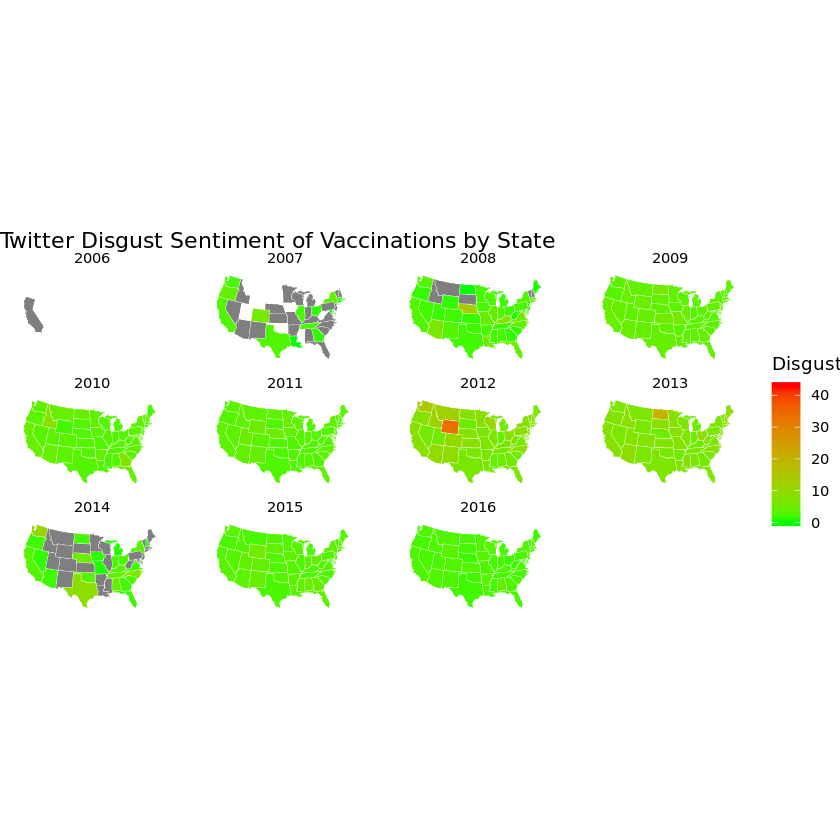

In [19]:
##DISGUST## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=disgust/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "green", high = "red", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Disgust" 
                            ,title = "Twitter Disgust Sentiment of Vaccinations by State", x="", y="")+
theme_void() + facet_wrap(~year)

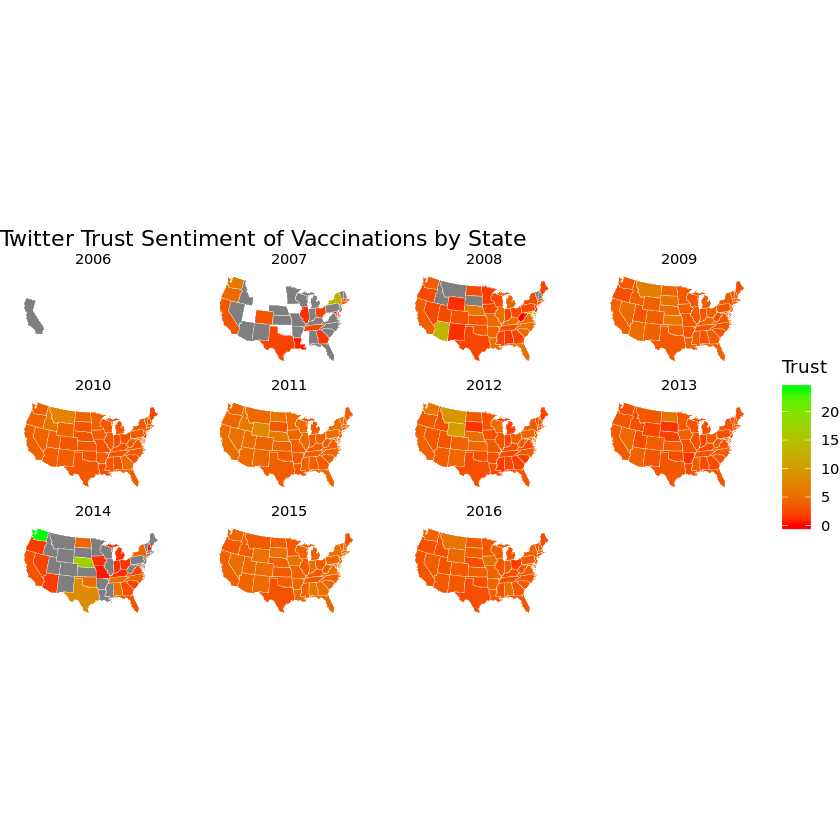

In [20]:
##TRUST## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=trust/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "red", high = "green", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Trust" 
                            ,title = "Twitter Trust Sentiment of Vaccinations by State", x="", y="")+
theme_void() + facet_wrap(~year)

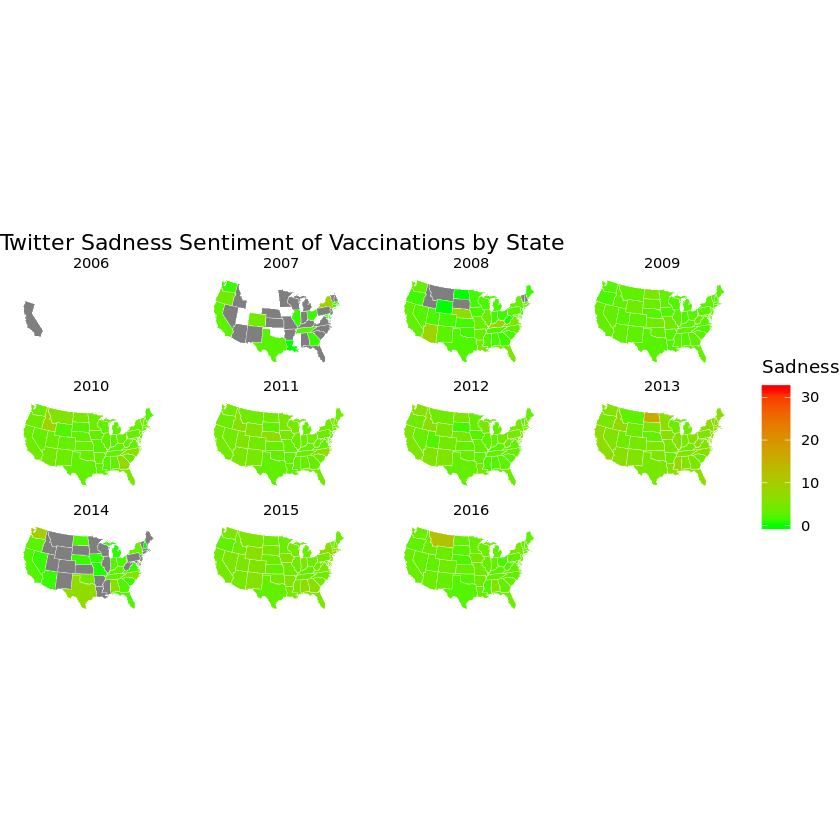

In [21]:
##SADNESS## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=sadness/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "green", high = "red", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Sadness" 
                            ,title = "Twitter Sadness Sentiment of Vaccinations by State", x="", y="")+
theme_void() + facet_wrap(~year)

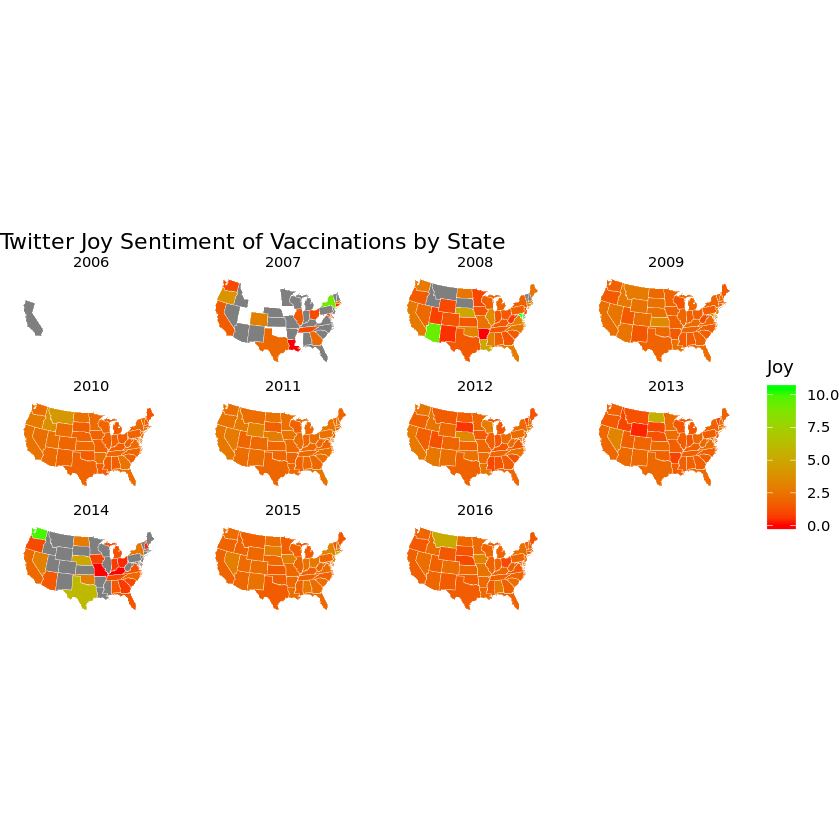

In [22]:
 ##JOY## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=joy/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "red", high = "green", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Joy" 
                            ,title = "Twitter Joy Sentiment of Vaccinations by State", x="", y="")+
theme_void() + facet_wrap(~year)

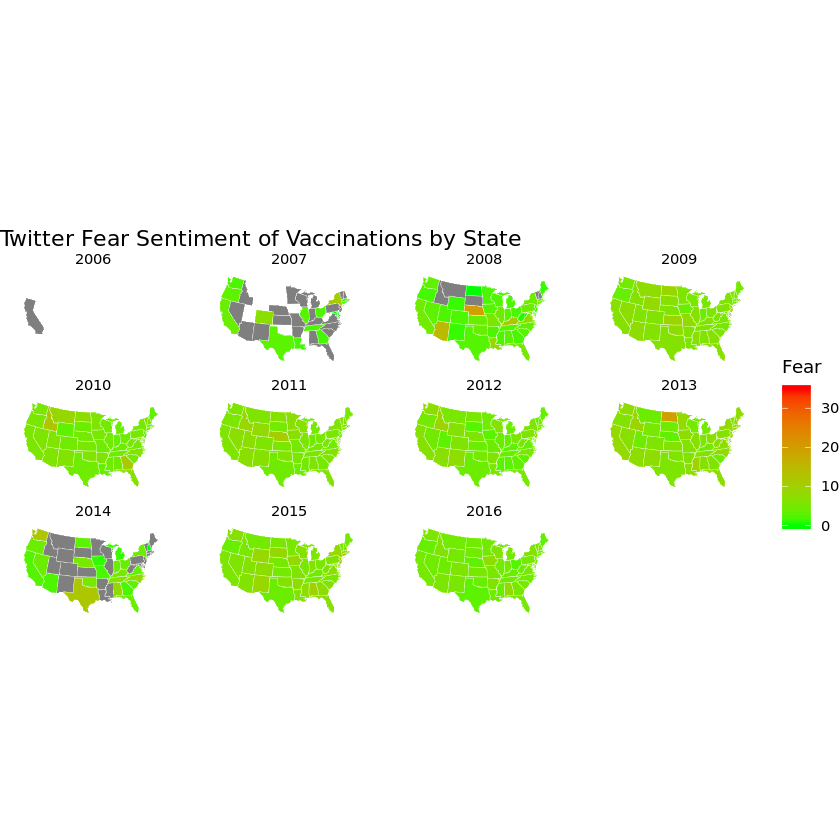

In [23]:
##FEAR## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=fear/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "green", high = "red", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Fear" 
                            ,title = "Twitter Fear Sentiment of Vaccinations by State", x="", y="")+
theme_void() + facet_wrap(~year)

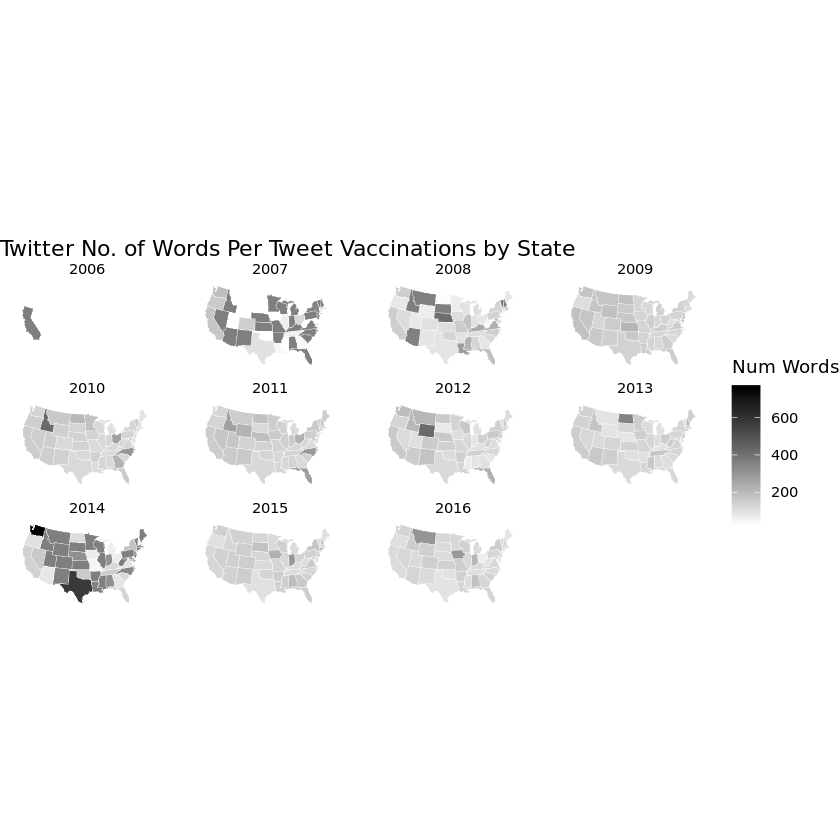

In [24]:
##TOT_NUM_WORDS## LETS  VIEW QUANTITATIVE TRENDS IN GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=n_words/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "white", high = "black", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Num Words" 
                            ,title = "Twitter No. of Words Per Tweet Vaccinations by State", x="", y="")+
theme_void() + facet_wrap(~year)

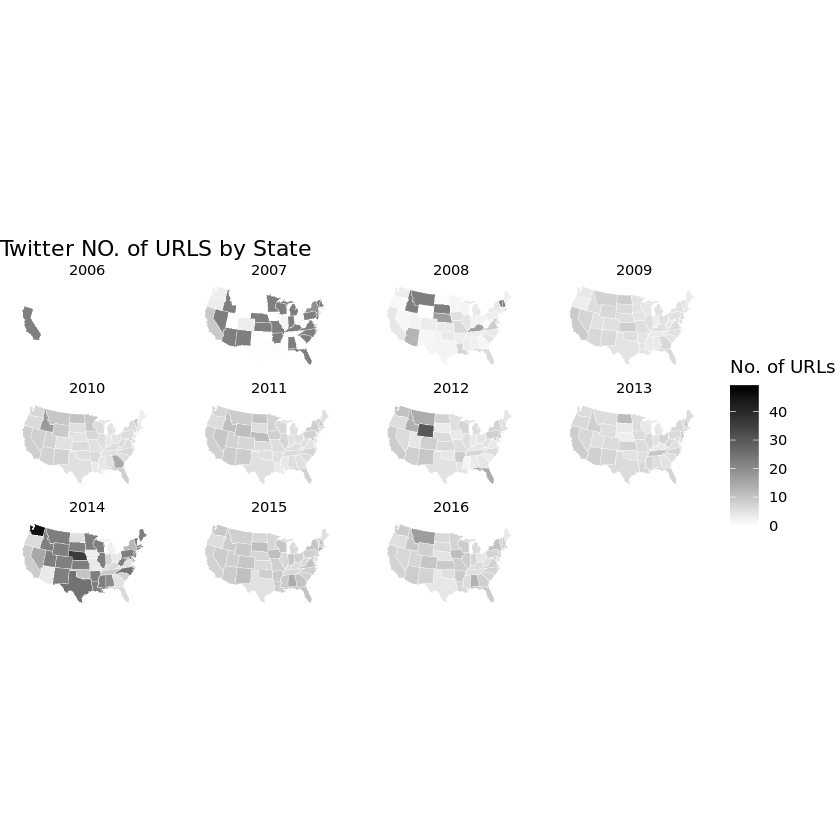

In [25]:
##TOTNUM URL## LETS VIEW QUANTITATIVE TRENDS IN GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=n_urls/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "white", high = "black", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "No. of URLs" 
                            ,title = "Twitter NO. of URLS by State", x="", y="")+
theme_void() + facet_wrap(~year)

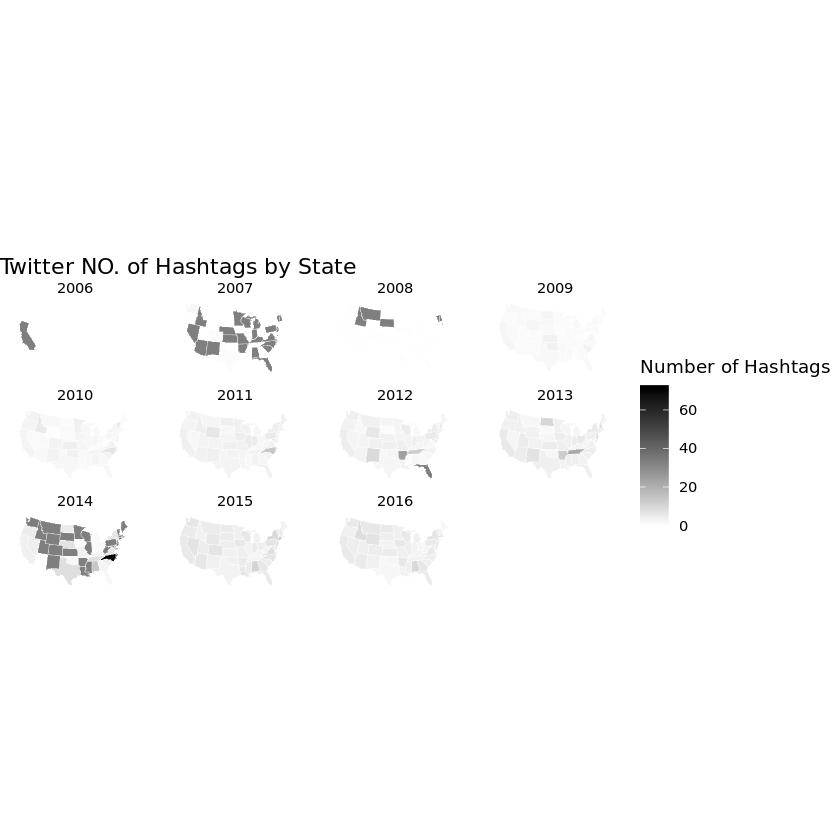

In [26]:
##TOTNUM HASHTAGS## LETS VIEW QUANTITATIVE DATA IN GRAYSCALE

ggplot(data=tweetwithoutbot, aes(fill=n_hashtags/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "white", high = "black", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Number of Hashtags " 
                            ,title = "Twitter NO. of Hashtags by State", x="", y="")+
theme_void() +facet_wrap(~year)

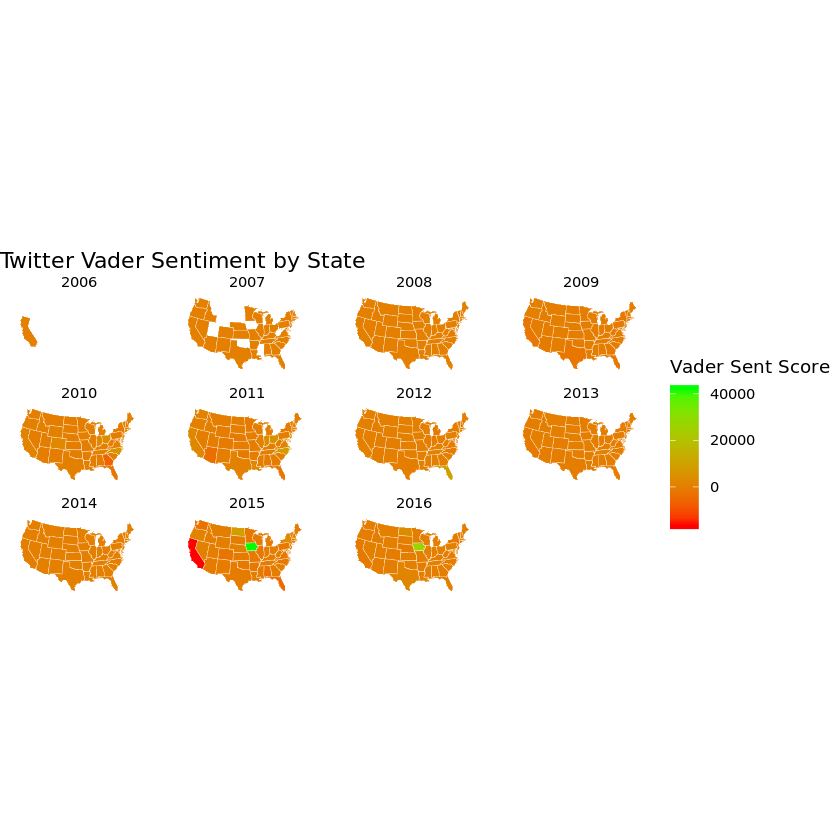

In [27]:
##VADER SENTIMENT## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=sent_vader)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "red", high = "green", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Vader Sent Score " 
                            ,title = "Twitter Vader Sentiment by State", x="", y="")+
theme_void() +facet_wrap(~year)

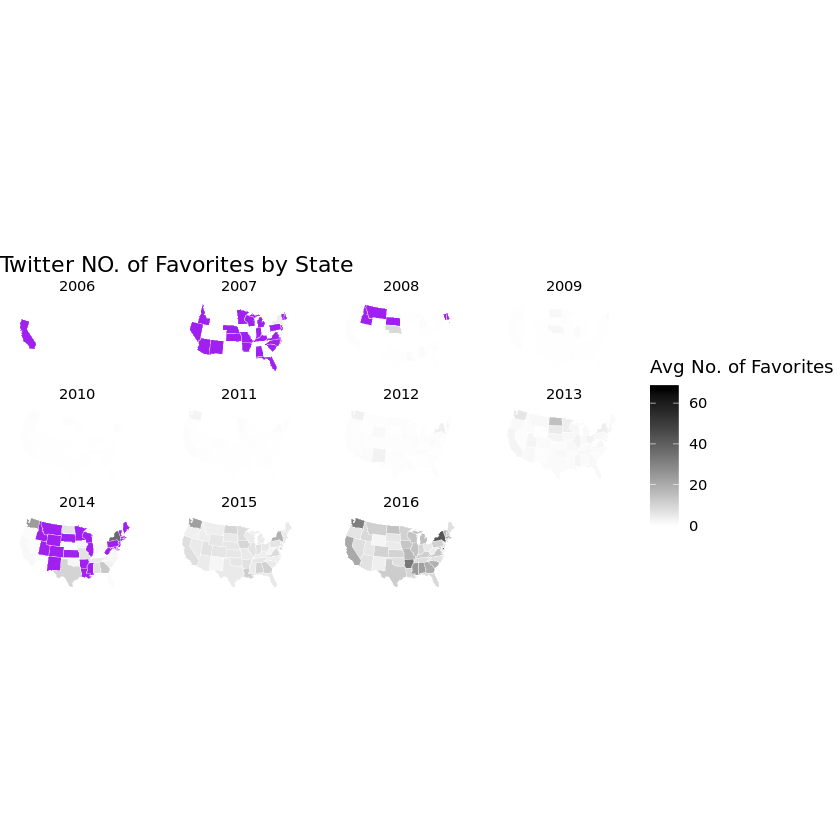

In [28]:
##favorites## LETS VIEW QUANTITATIVE DATA IN GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=favorite_count/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "white", high = "black", guide="colorbar",na.value="purple") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Avg No. of Favorites" 
                            ,title = "Twitter NO. of Favorites by State", x="", y="")+
theme_void() + facet_wrap(~year)

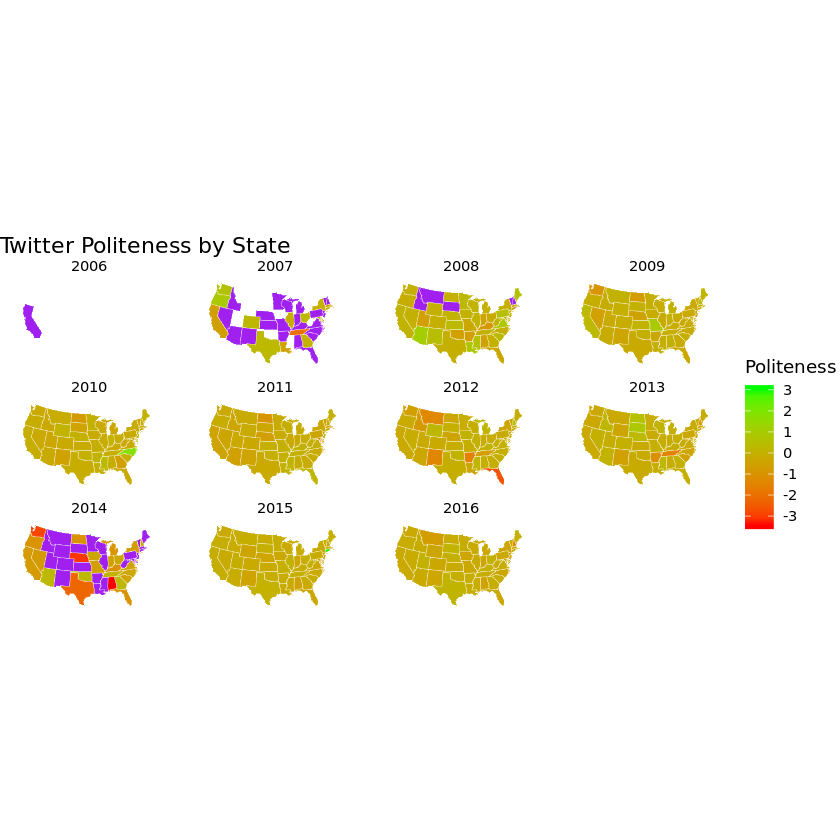

In [29]:
##NO POLITE## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=n_polite/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "red", high = "green", guide="colorbar",na.value="purple") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Politeness" 
                            ,title = "Twitter Politeness by State", x="", y="")+
theme_void() + facet_wrap(~year)

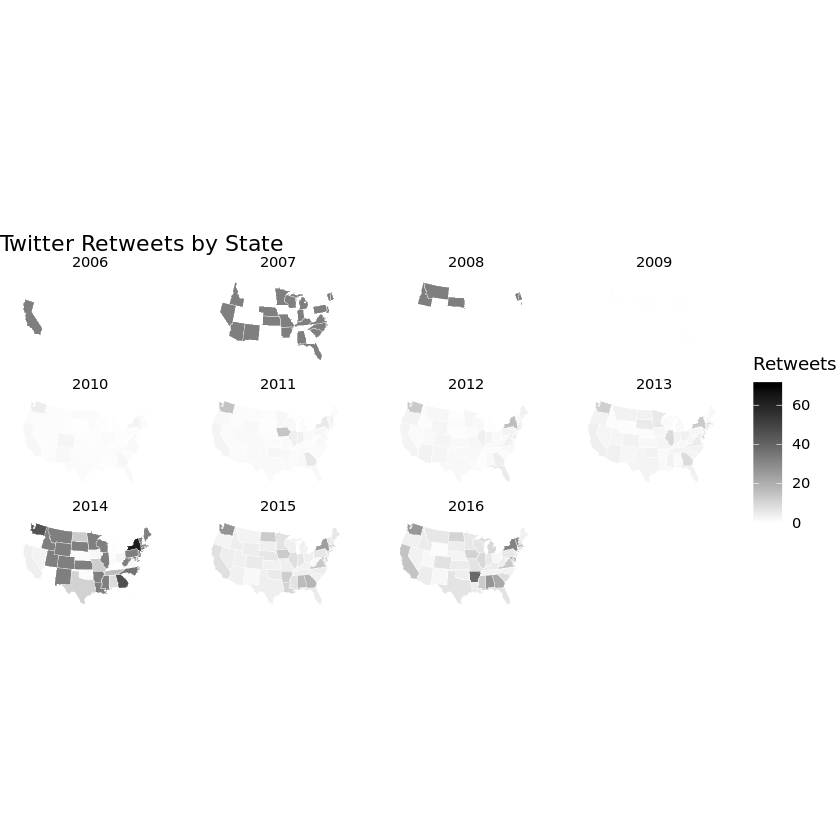

In [30]:
##RETWEET COUNT## LETS VIEW QUANTITATIVE DATA IN GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=retweet_count/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "white", high = "black", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Retweets" 
                            ,title = "Twitter Retweets by State", x="", y="")+
theme_void() + facet_wrap(~year)

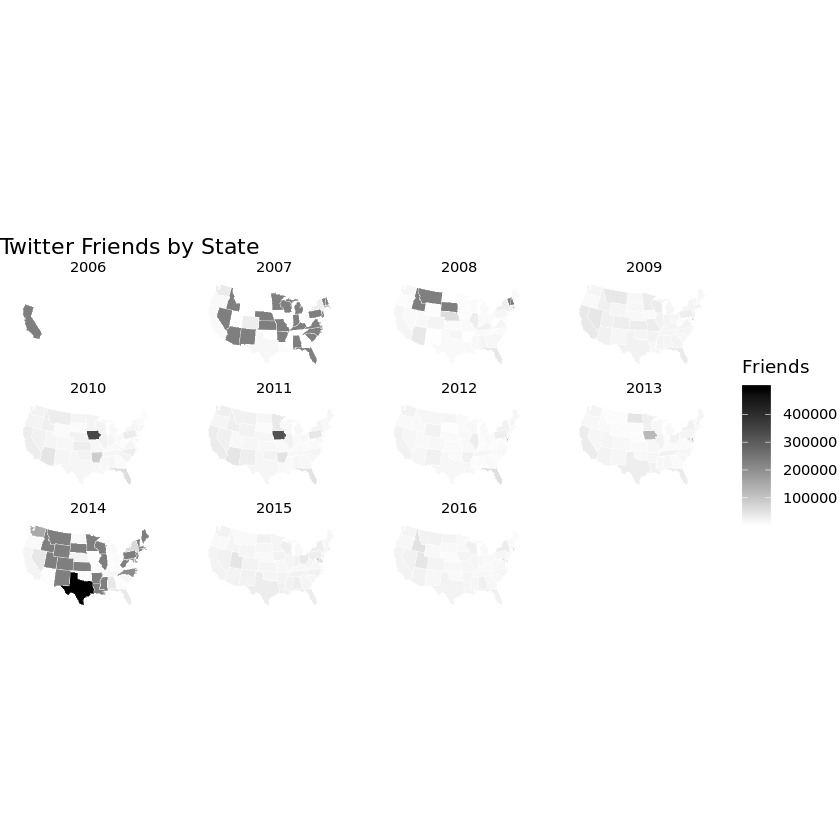

In [31]:
##FRIENDS COUNT## QUANTITATIVE DATA IN GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=friends_count/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "white", high = "black", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Friends" 
                            ,title = "Twitter Friends by State", x="", y="")+
theme_void() + facet_wrap(~year)

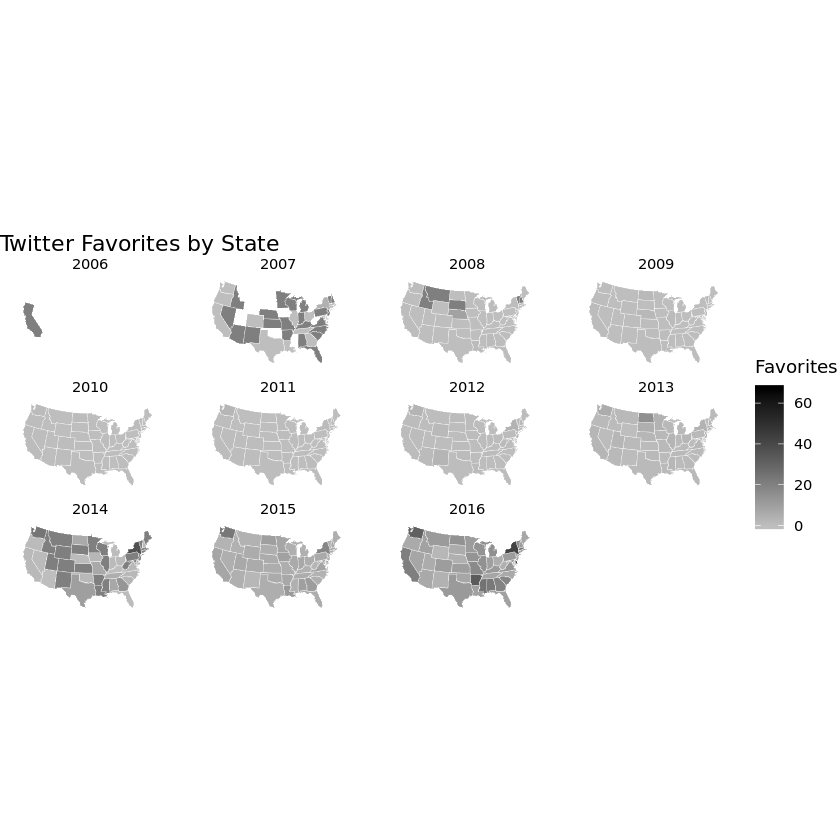

In [32]:
##FAVORITE COUNT## QUANTITATIVE DATA IN GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=favorite_count/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "gray", high = "black", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Favorites" 
                            ,title = "Twitter Favorites by State", x="", y="")+
theme_void() + facet_wrap(~year)

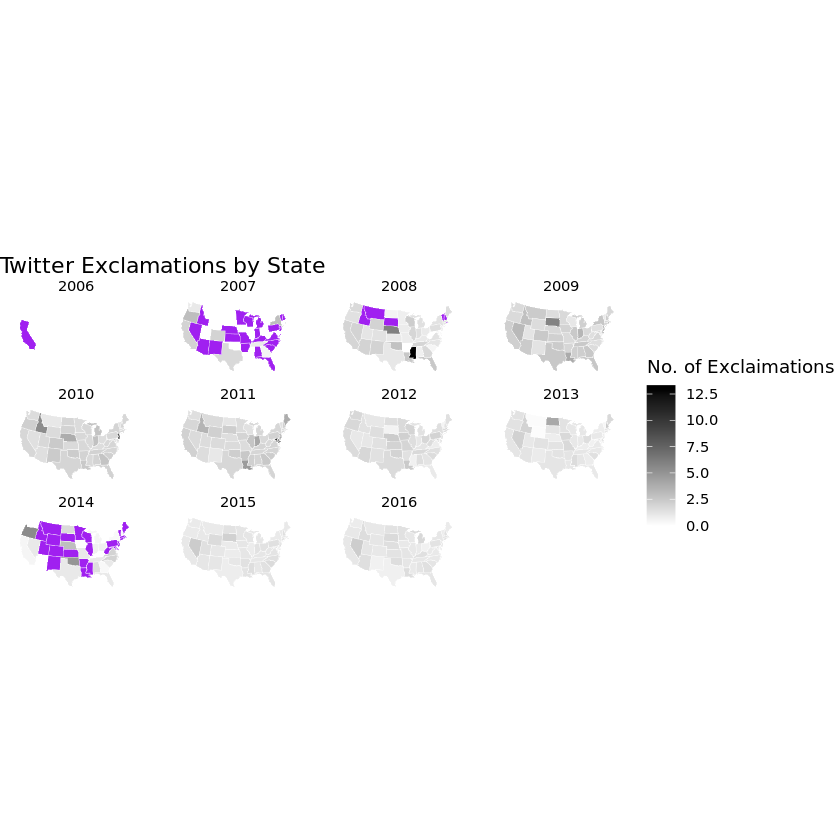

In [33]:
#EXCLAIMS COUNT## QUANTITATIVE DATA IN GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=n_exclaims/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "white", high = "black", guide="colorbar",,na.value="purple") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "No. of Exclaimations" 
                            ,title = "Twitter Exclamations by State", x="", y="")+
theme_void() + facet_wrap(~year)

In [ ]:
##VERIFIED COUNT## QUANTITATIVE DATA IN GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=verified/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "white", high = "black", guide="colorbar",,na.value="purple") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Verified" 
                            ,title = "Twitter Verified by State", x="", y="")+
theme_void() + facet_wrap(~year)

In [ ]:
##AFINN COUNT## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=sent_afinn)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "red", high = "green", guide="colorbar") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Cumulative Sentiment" 
                            ,title = "Twitter Sentiment Afinn by State", x="", y="")+
theme_void() + facet_wrap(~year)

In [ ]:
#LETS LOOK AT PREDICTIVE DATA
head(preds)
colnames(preds)

In [ ]:
##preds COUNT## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=tweetwithoutbot, aes(fill=n_uq_hashtags/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "red", high = "green", guide="colorbar", na.value="purple") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "No. Hashtags" 
                            ,title = "No. of Unique Hashtags by State", x="", y="")+

theme_void() + facet_wrap(~year)

In [ ]:
##preds COUNT## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=preds, aes(fill=Rate)) + 
geom_map(map=states_map, aes(map_id=State), color="white", size=0.1) +

expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Rate" 
                            ,title = "Immunization Actual Rate by State", x="", y="")+
scale_fill_gradientn(colours = c("red", "orange", "yellow", "green", "blue"),
                       breaks=c(0,25,50,75,100),
                       na.value = "black", limits=c(0,100))+

theme_void() + facet_wrap(~Year)

In [ ]:
##preds COUNT## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=preds, aes(fill=preds.no.twitter)) + 
geom_map(map=states_map, aes(map_id=State), color="white", size=0.1) +

expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Rate" 
                            ,title = "Immunization Prediction Rate w/o Twitter by State", x="", y="")+
scale_fill_gradientn(colours = c("red", "orange", "yellow", "green", "blue"),
                       breaks=c(0,25,50,75,100),
                       na.value = "black", limits=c(0,100))+

theme_void() + facet_wrap(~Year)

In [ ]:
##preds COUNT## LETS  VIEW NEGATIVE (AGAINST VACCINATION) TRENDS AS RED AND POSITIVE (FOR VACCINATION) TRENDS IN GREEN
ggplot(data=preds, aes(fill=preds.with.twitter)) + 
geom_map(map=states_map, aes(map_id=State), color="white", size=0.1) +

expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "Rate" 
                            ,title = "Immunization Prediction Rate with Twitter by State", x="", y="")+
scale_fill_gradientn(colours = c("red", "orange", "yellow", "green", "blue"),
                       breaks=c(0,25,50,75,100),
                       na.value = "black", limits=c(0,100))+

theme_void() + facet_wrap(~Year)

In [ ]:
textfeat<-tweetwithoutbot %>%
 select(2,3,32:52,57:64) 
colnames(textfeat)

In [ ]:
bothdf <- merge(rate,tweetwithoutbot,by=c("state","year"))
bothdf<-write.csv(bothdf,file="../Resources/bothdf.csv")

In [ ]:
##n_nonasciis## QUANTITATIVE DATA IN GRAYSCALE
ggplot(data=tweetwithoutbot, aes(fill=n_nonasciis/cnt)) + 
geom_map(map=states_map, aes(map_id=state), color="white", size=0.1) +
scale_fill_continuous(low = "white", high = "black", guide="colorbar",na.value = "purple") + 
expand_limits(x = states_map$long, y = states_map$lat) + 
coord_map("polyconic") +
labs(fill = "No of Non Asciis" 
                            ,title = "Twitter No. of Non Asciis by State", x="", y="")+
theme_void() + facet_wrap(~year)